# Visualize Emotions Results for Israel-Hamas Data

## Imports

### Library Imports

In [262]:
import pandas as pd
import numpy as np

import json

import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colormaps
from matplotlib import colors

from datetime import datetime, timedelta

### Data Import and Prep

In [2]:
# emotions annotations
fpath = "C:/Data/INCAS/challenge_problem_two_21NOV/challenge_problem_two_21NOV--emotion_annotated-2023-12-06--17-43-55.539838.csv"
emo = pd.read_csv(fpath)

# challenge data 2
fpath = "C:/Data/INCAS/challenge_problem_two_21NOV/challenge_problem_two_21NOV.jsonl"
challenge = pd.read_json(path_or_buf=fpath, lines=True)[['embeddedUrls', 'author', 'contentText',
                                                         'id', 'language', 'mediaType',
                                                         'timePublished', 'title', 'url']]

# associate data with annotations
df = pd.merge(left=emo, right=challenge, how='left',
              left_on='tweet_id', right_on='id')
df.drop(columns=['tweet_id'], inplace=True)

# get subset of data
twitter = df[df['mediaType']=='Twitter']
twitter.columns

Index(['Anger', 'Anticipation', 'Disgust/Contempt', 'Fear', 'Joy', 'Love',
       'Optimism', 'Pessimism', 'Sadness', 'Surprise', 'Trust',
       'No emotion detected', 'embeddedUrls', 'author', 'contentText', 'id',
       'language', 'mediaType', 'timePublished', 'title', 'url'],
      dtype='object')

In [6]:
# associate data with annotations
df = pd.merge(left=emo, right=challenge, how='left',
              left_on='tweet_id', right_on='id')
df.drop(columns=['tweet_id'], inplace=True)

# get publication date-time
df['date_time'] = pd.to_datetime(df['timePublished'], unit='ms')

# get subset of data
twitter = df[df['mediaType']=='Twitter']
twitter.columns

Index(['Anger', 'Anticipation', 'Disgust/Contempt', 'Fear', 'Joy', 'Love',
       'Optimism', 'Pessimism', 'Sadness', 'Surprise', 'Trust',
       'No emotion detected', 'embeddedUrls', 'author', 'contentText', 'id',
       'language', 'mediaType', 'timePublished', 'title', 'url', 'date_time'],
      dtype='object')

## Visualize Daily Mean Confidence for Each Emotion

### Core Functions

In [212]:
def add_annotation(ax, text, x, y, text_color='#404040',
                   text_size=13, line_thickness=1.0,
                   line_color='#404040', horizontal_alignment='left',
                   text_spacer=4, annotation_edge_color='white'):
    """Add an annotation to the plot."""

    if horizontal_alignment == 'left':
        text_spacer0 = text_spacer
    elif horizontal_alignment == 'right':
        text_spacer0 = -text_spacer
    else:
        print("Please select either 'left' or 'right' for horizontal_alignment.")

    # plot vertical line indicating location
    plt.plot([x, x], [0, y], linewidth=line_thickness, color=line_color)

    # add annotation
    ax.text(x+timedelta(days=text_spacer0),
            y,
            text,
            fontsize=text_size,
            verticalalignment='top',
            horizontalalignment=horizontal_alignment,
            color=text_color,
            bbox=dict(facecolor='white', edgecolor=annotation_edge_color))

def add_line_annotation(ax, text, x, y0, y1, text_color='#404040',
                   text_size=13, line_thickness=1.0,
                   line_color='#404040', horizontal_alignment='left',
                   text_spacer=4, annotation_edge_color='white'):
    """Add an annotation to the plot that points at one of the lines."""

    if horizontal_alignment == 'left':
        text_spacer0 = text_spacer
    elif horizontal_alignment == 'right':
        text_spacer0 = -text_spacer
    else:
        print("Please select either 'left' or 'right' for horizontal_alignment.")

    # plot vertical line indicating location
    plt.plot([x, x], [y0, y1], linewidth=line_thickness, color=line_color)

    # add annotation
    ax.text(x+timedelta(days=text_spacer0),
            y1,
            text,
            fontsize=text_size,
            verticalalignment='top',
            horizontalalignment=horizontal_alignment,
            color=text_color,
            bbox=dict(facecolor='white', edgecolor=annotation_edge_color))


def add_overarching_claim_data(L2_claim_id):

    # Get all articles which contain the specified claim
    claim_data = claims[['L2_Claim_Text', 'Source_Document_ID', 'Date_Time']][claims['L2_Claim_ID']==L2_claim_id].copy()
    claim_data.drop_duplicates(subset='Source_Document_ID', inplace=True, ignore_index=True)

    # Get the text of the specified claim
    claim_txt = claim_data.iloc[0]['L2_Claim_Text']

    # Count the number of articles per time period
    art_counts = pd.DataFrame(claim_data['Date_Time'].value_counts()).resample('W').sum()

    plt.plot(art_counts.index,
             art_counts['Date_Time'])

    return claim_txt

In [310]:
def create_emotion_timeline_figure(figsize=(14, 6), y_min=None, y_max=None):
    plt.figure(figsize=figsize)

    ## Style Figure
    # get axes to customize
    ax = plt.gca()

    # Set visibility of lines around figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Specify the size and color of spines
    ax.spines['bottom'].set_color('#D9D9D9')
    ax.spines['bottom'].set_linewidth(0.75)

    # Specify the color of ticks on x and y axes
    ax.tick_params(axis='both', colors='#D9D9D9', labelsize=13)

    # Format the x-axis as date
    plt.gca().xaxis_date()
    plt.gcf().autofmt_xdate(rotation=0,
                            ha='center')

    # Set the date format for the x-axis
    date_format = mdates.DateFormatter('%b %e, %Y')
    ax.xaxis.set_major_formatter(date_format)

    # set the y-axis limits and scale
    if (y_min != None) & (y_max != None):
        ax.set_ylim(y_min, y_max)

    if (((y_min != None) & (y_max == None))
        | ((y_min == None) & (y_max != None))):
        print("Please specify both upper and lower bounds for the y-axis.")

    # # Set visibility of lines around figure
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # # Specify the size and color of spines
    # ax.spines['bottom'].set_color('#D9D9D9')
    # ax.spines['bottom'].set_linewidth(0.75)

    # # Specify the color of ticks on x and y axes
    # ax.tick_params(axis='both', colors='#D9D9D9')  # , labelsize=13)

    # Changing the color of the tick labels
    for label in ax.xaxis.get_ticklabels():
        label.set_color('#404040')
    for label in ax.yaxis.get_ticklabels():
        label.set_color('#404040')

    # add major gridelines for y-axis and style
    ax.yaxis.grid(True, linewidth=0.5, color='#D9D9D9')

    return ax

def plot_document_counts(x, y, color = '#990000', linewidth = 2.5, label=""):
    plt.plot(x,
             y,
             color = color,
             linewidth = linewidth,
             label=label)

### All Emotions One Chart - Daily Mean Confidence

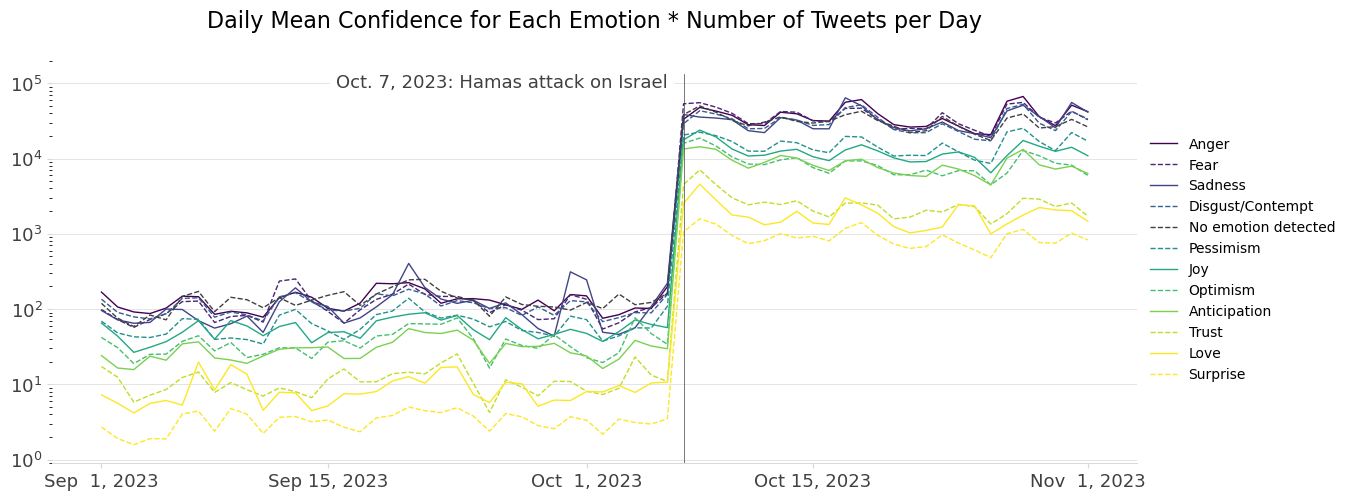

In [314]:
ax = create_emotion_timeline_figure()

# set to true to have all emotions except the
# one specified colored gray. This makes the
# specified emotion stand out
highlight = False  # True False
highlight_emotion = 'Sadness'

# emotion colors to change: Joy, Optimism, Anger

# get the order of emotions in descending order of
# average confidence, so highest confidence values
# are drawn last
emo_order = (twitter[['Anger', 'Anticipation', 'Disgust/Contempt', 'Fear',
                      'Joy', 'Love', 'Optimism', 'Pessimism',
                      'Sadness', 'Surprise', 'Trust', 'No emotion detected']]
                      .mean()
                      .sort_values()
                      .index)
emo_order = list(emo_order)[::-1]

# get daily mean confidence values
twitter_daily = (twitter[emo_order]
                 .groupby(twitter['date_time'].dt.date)
                 .mean())


# get counts of tweets per day
twitter_daily_counts = (twitter[['date_time']]
                        .groupby(twitter['date_time'].dt.date)
                        .count())

# get daily confidences weighted by number of tweets on the day
twitter_daily = twitter_daily.multiply(twitter_daily_counts['date_time'], axis=0)

# colors = ['#543005','#8c510a','#bf812d','#dfc27d',
#           '#f6e8c3','#f5f5f5','#c7eae5','#80cdc1',
#           '#35978f','#01665e','#003c30'][::-1]

# colors = ['#40004b','#762a83','#9970ab','#c2a5cf',
#           '#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0',
#           '#5aae61','#1b7837','#00441b'][::-1]

# neg_colors = ['#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026'][::-1]
# pos_colors = ['#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0','#034e7b']

# neg_colors = ['#a6a6a6', '#df65b0','#e7298a','#ce1256','#980043','#67001f'][::-1]
# pos_colors = ['#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b'][::-1]
# pos_colors = ['#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081']
# colors = neg_colors + pos_colors

# color_dict = {
#     'Anger': ['#d73027', '-'],
#     'Fear': ['#d73027', '--'],
#     'Sadness': ['#fdae61', '-'],
#     'Disgust/Contempt': ['#fdae61', '--'],
#     'Pessimism': ['#d73027', 'dotted'],
#     'No emotion detected': ['#404040', '-'],
#     'Joy': ['#4575b4', '-'],
#     'Optimism': ['#4575b4', '--'],
#     'Anticipation': ['#abd9e9', '-'],
#     'Trust': ['#abd9e9', '--'],
#     'Love': ['#542788', 'dotted'],
#     'Surprise': ['#b2abd2', 'dotted']
# }

# make highlight emotion the last one in the list so it
# is drawn on top of others
# if highlight:
#     idx = emo_order.index(highlight_emotion)

#     # put highlight emotion at the end of the list
#     emo_order.remove(highlight_emotion)
#     emo_order.append(highlight_emotion)

#     # put the highlight emotion's color at the end of the list
#     highlight_color = colors.pop(idx)
#     colors.append(highlight_color)

# Get the Viridis colormap
viridis = colormaps['viridis']

# Normalizing the index for colormap
norm = colors.Normalize(vmin=0, vmax=12 - 2)



for i, emotion in enumerate(emo_order):
    line_width=1.0
    # if highlight & (emotion!=highlight_emotion):
    #     # color = '#000000' # '#a6a6a6' '#E7E6E6' '#767171' '#D0CECE' C9C9C9 595959
    #     line_width = 1.0
    #     alpha = 0.3

    # if highlight & (emotion==highlight_emotion):
    #     # if highlight_emotion in ['Anticipation', 'Joy', 'Love', 'Optimism', 'Trust', 'Surprise']:
    #     #     color = '#2c7bb6'
    #     # else:
    #     #     color = '#d7191c' # '#4f81bd' '#d7191c'  # 000000
    #     line_width=3.0
    #     alpha = 1.0
    
    # # specify emotions to get dashed lines
    # dashed_emotions = emo_order[1::2]
    # if emotion in dashed_emotions:
    #     linestyle = '--'
    # else:
    #     linestyle = '-'

    if emotion == 'No emotion detected':
        color = '#404040'
    else:
        color = viridis(norm(i))

    if ((i)%2==0) & (emotion != 'No emotion detected'):
        linestyle = '-'
    # if emotion == 'No emotion detected':
    #     linestyle='dotted'
    else:
        linestyle = '--'

    plt.plot(twitter_daily.index,
             twitter_daily[emotion],
             linestyle=linestyle,
             label=emotion,
             c=color,
             linewidth=line_width,
             alpha=1)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=7))

add_annotation(ax,
               "Oct. 7, 2023: Hamas attack on Israel",
               pd.to_datetime(datetime(2023, 10,7).date()),
               twitter_daily.max().max()*2,
               horizontal_alignment='right',
               line_thickness=0.5,
               text_spacer=1)

# add_annotation(ax,
#                "Tweet about the 23rd anniversary of the killing \nof 12-year-old Muhammad al-Durrah by Israeli \nforces retweeted 227 times.",
#                pd.to_datetime(datetime(2023, 9, 30).date()),
#                0.55,
#                horizontal_alignment='right',
#                text_spacer=1)

plt.yscale('log')

# if not highlight:
plt.legend(loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False)

# if highlight:
#     plt.title(f"Daily Mean Confidence for {highlight_emotion}",
#             fontsize=16,
#             loc='center',
#             pad=20)
# else:
plt.title("Daily Mean Confidence for Each Emotion * Number of Tweets per Day",
        fontsize=16,
        loc='center',
        pad=20)

plt.show()

### Separate Charts for Each Emotion

In [194]:
# get daily mean confidence values per emotion
twitter_daily = (twitter[emo_order]
                 .groupby(df['date_time'].dt.date)
                 .mean())

# Get the daily average across all emotions
emo_dfs = [twitter[['date_time', emo]].rename(columns={emo:'confidence'}) for emo in emo_order]
emo_confidences = pd.concat(emo_dfs)
daily_emo_confid = emo_confidences.groupby(emo_confidences['date_time'].dt.date).mean()

C:\Users\djberry\AppData\Local\Temp\ipykernel_17356\2686668036.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_emo_confid = emo_confidences.groupby(emo_confidences['date_time'].dt.date).mean()


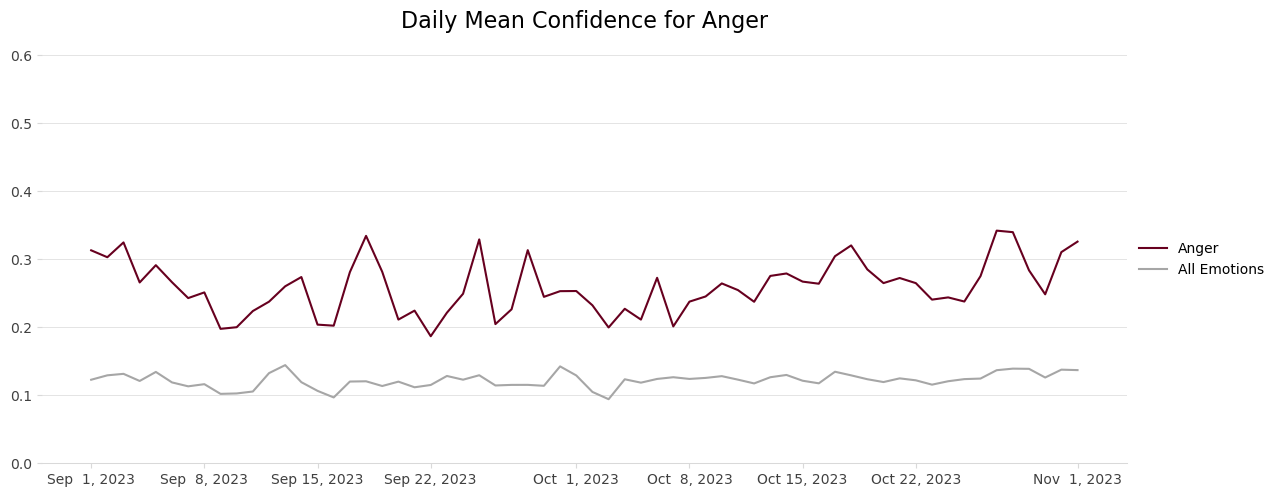

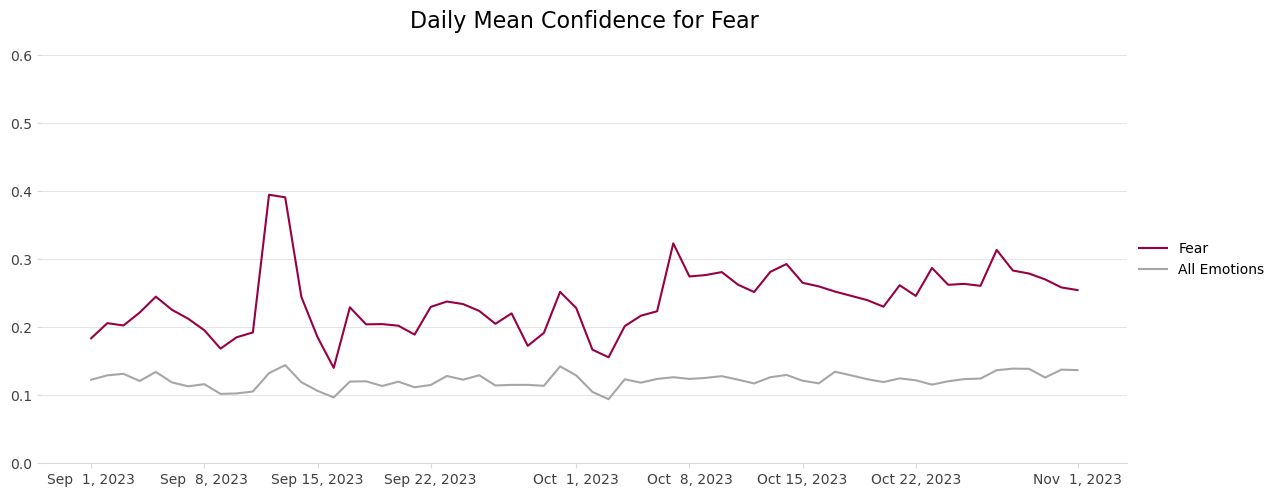

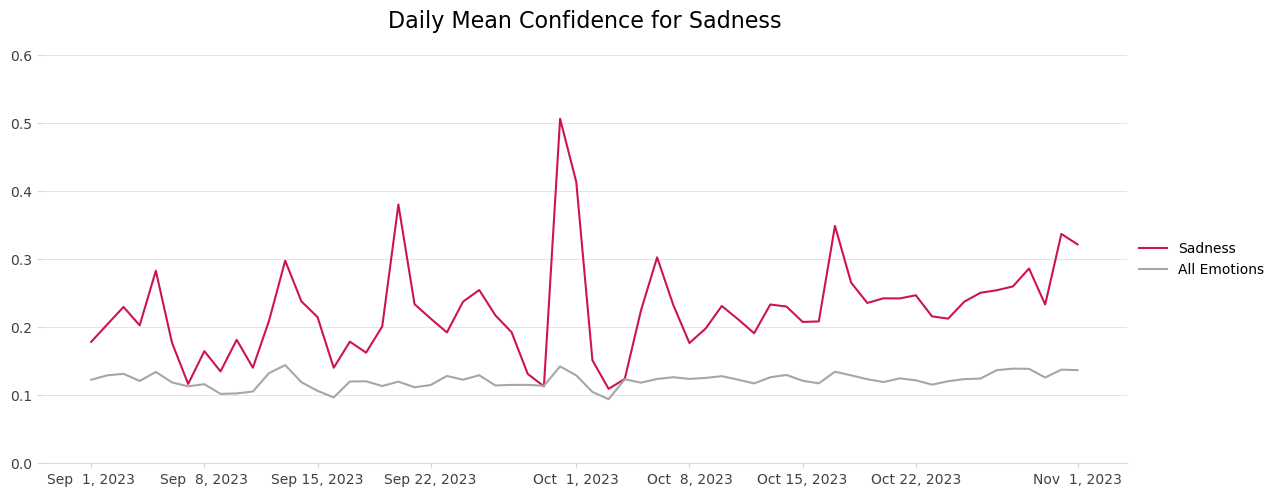

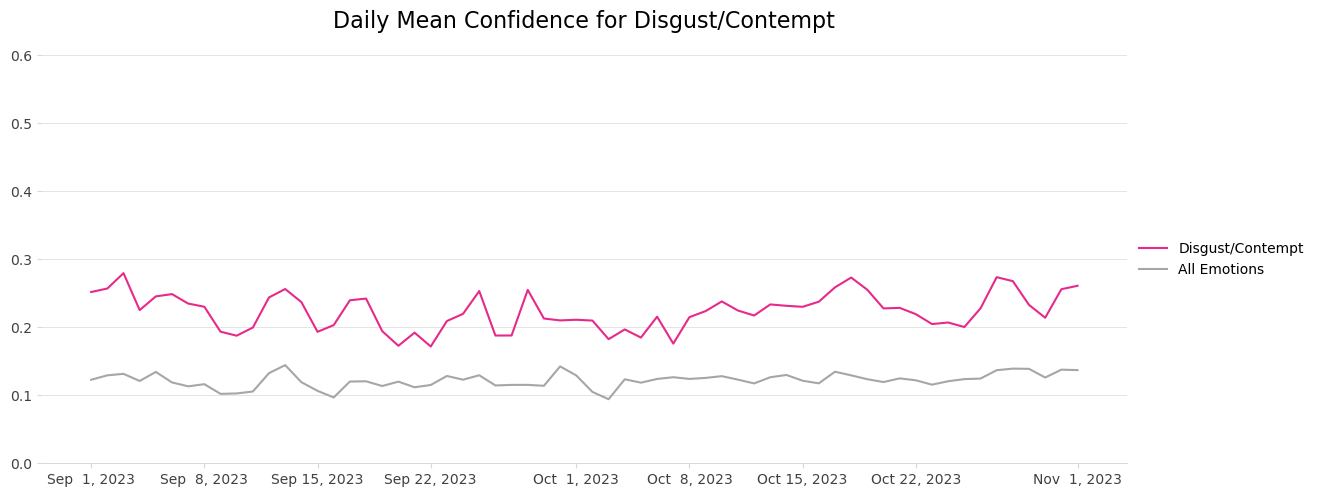

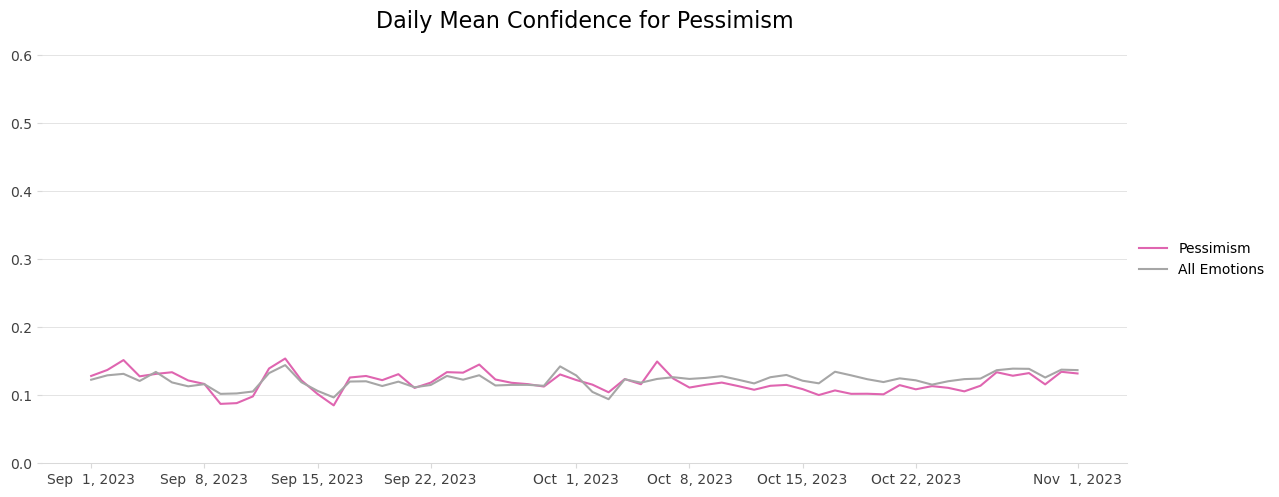

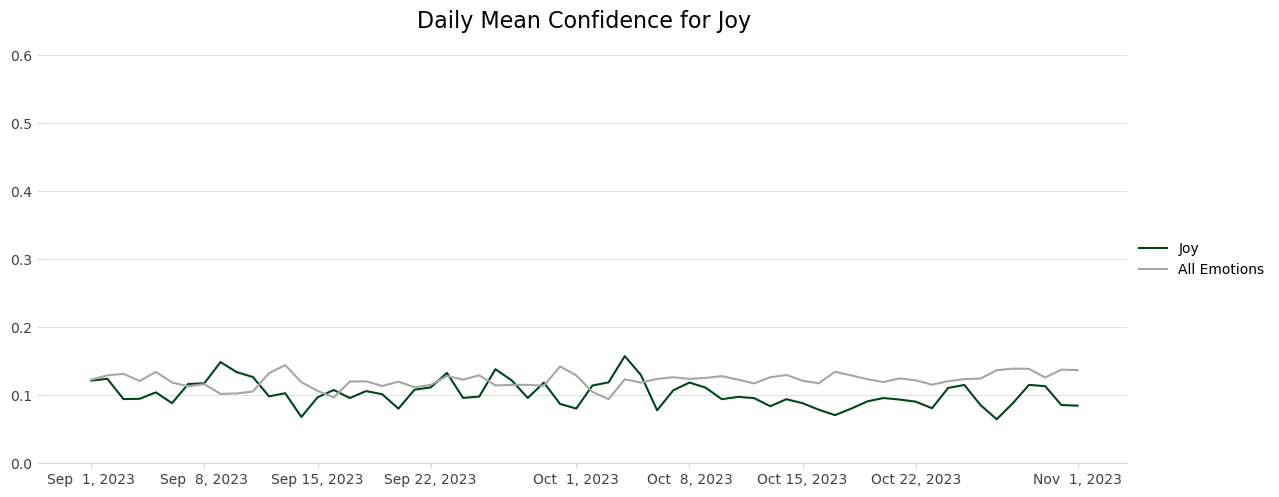

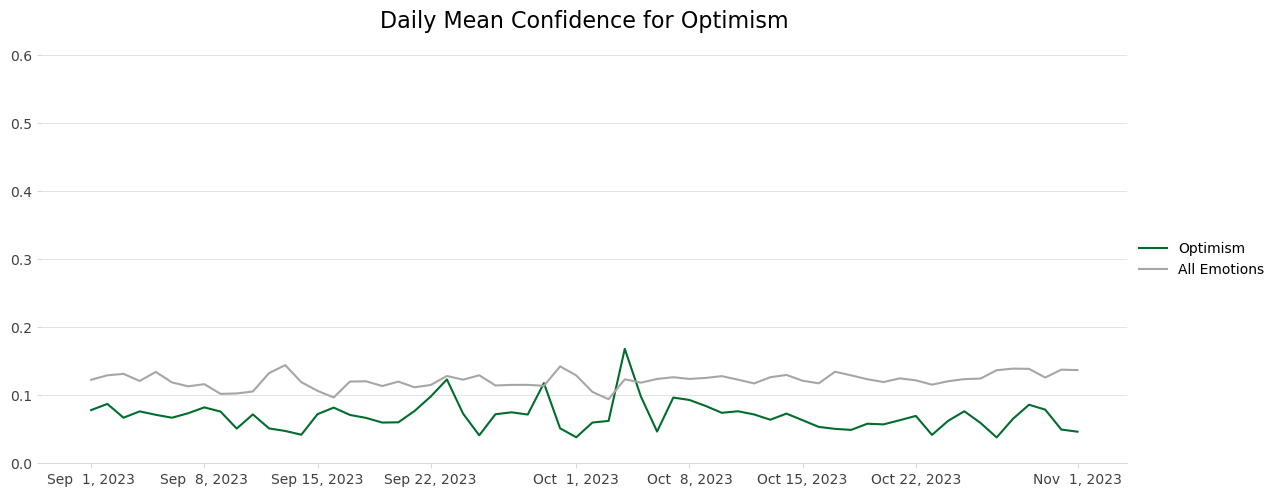

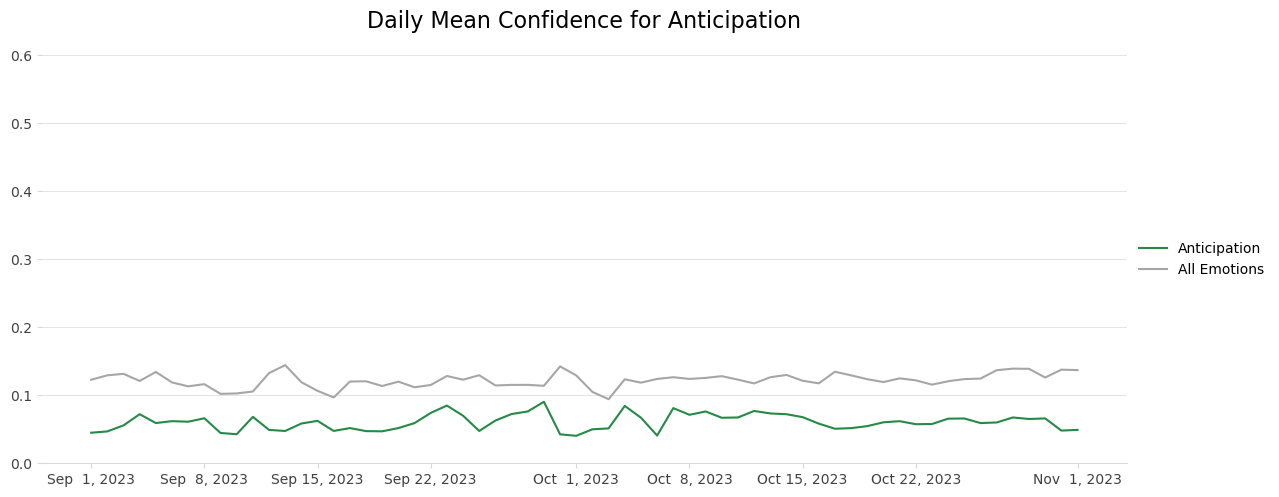

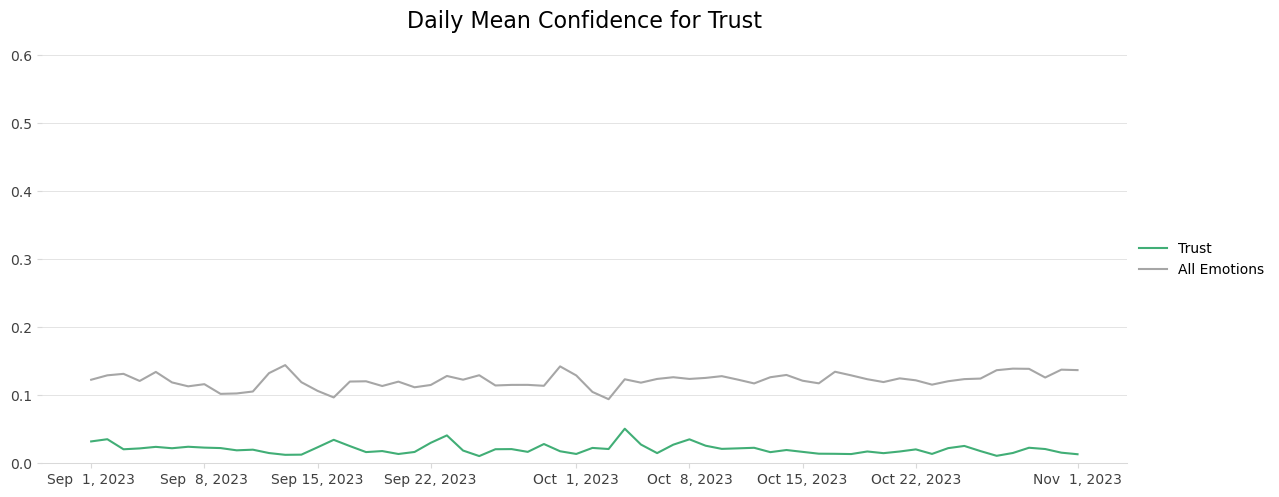

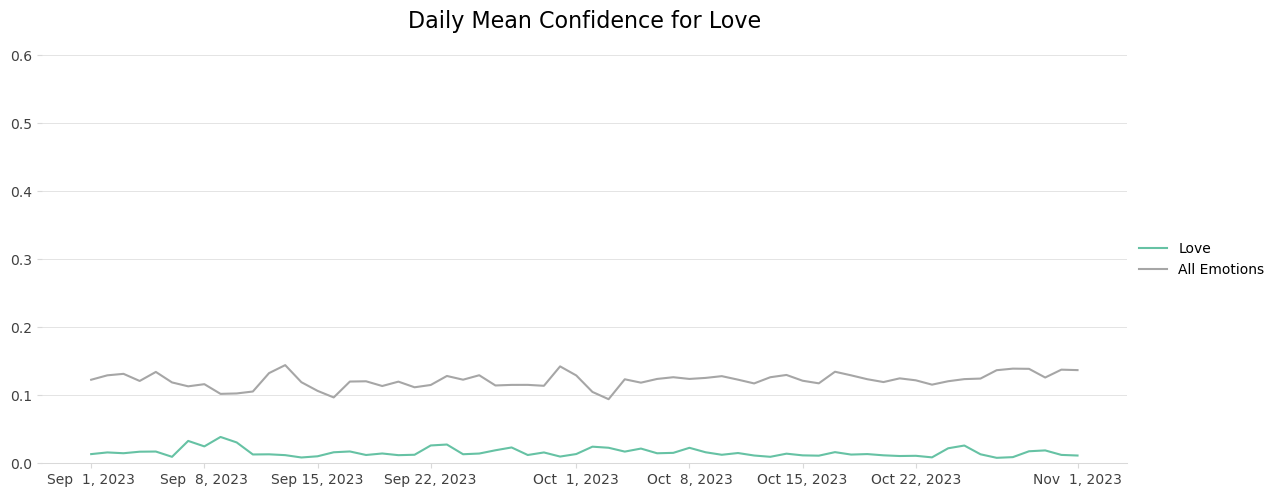

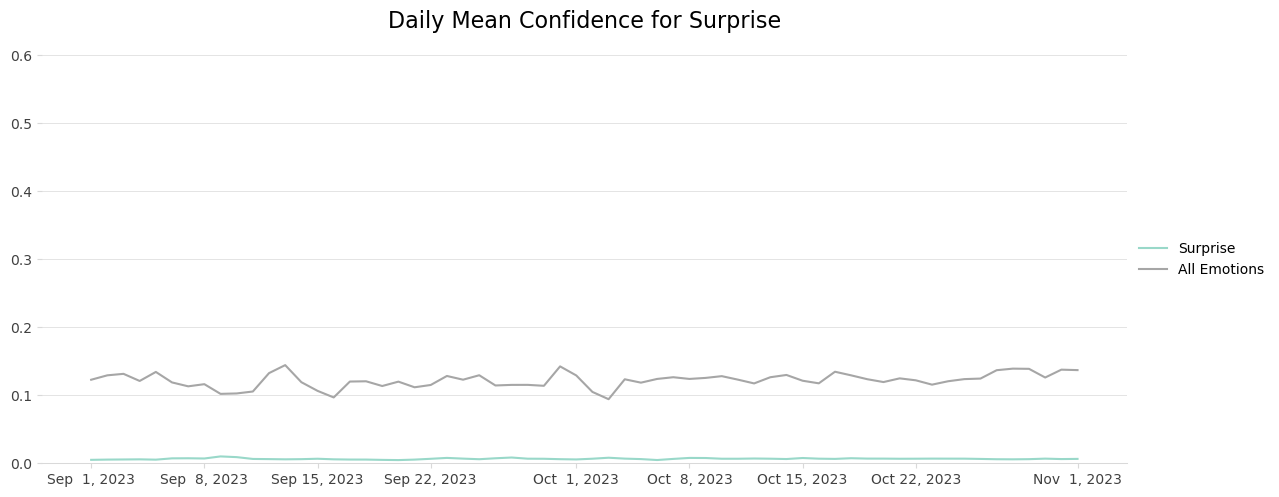

In [198]:
# get the order of emotions in descending order of
# average confidence, so highest confidence values
# are drawn last
emo_order = (twitter[['Anger', 'Anticipation', 'Disgust/Contempt', 'Fear',
                      'Joy', 'Love', 'Optimism', 'Pessimism',
                      'Sadness', 'Surprise', 'Trust']]
                      .mean()
                      .sort_values()
                      .index)
emo_order = list(emo_order)[::-1]

# emotion colors
emo_colors = {
    'Anger':'#67001f',
    'Fear':'#980043',
    'Sadness':'#ce1256',
    'Disgust/Contempt':'#e7298a',
    'Pessimism':'#df65b0',
    'Joy':'#00441b',
    'Optimism':'#006d2c',
    'Anticipation':'#238b45',
    'Trust':'#41ae76',
    'Love':'#66c2a4',
    'Surprise':'#99d8c9'
    }

for emotion in emo_order:
    ax = create_emotion_timeline_figure(y_min=0,
                                        y_max=0.6)
    plt.plot(twitter_daily.index,
             twitter_daily[emotion],
             c=emo_colors[emotion],
             label=emotion)
    
    plt.plot(daily_emo_confid.index,
             daily_emo_confid['confidence'],
             c="#a6a6a6",
             label="All Emotions")

    # set max and min y axis values
    plt.ylim((0,0.6))

    # ensure ticks don't overlap on x-axis
    # plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=3))

    # add legend
    plt.legend(loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False)
    
    plt.title(f"Daily Mean Confidence for {emotion}",
        fontsize=16,
        loc='center',
        pad=20)

    plt.show()

## Visualize Tweet Volume

In [274]:
twitter_daily_counts = (twitter[['date_time']]
                        .groupby(twitter['date_time'].dt.date)
                        .count())
twitter_daily_counts

,date_time
date_time,
2023-09-01,537
2023-09-02,352
2023-09-03,282
2023-09-04,328
2023-09-05,354
...,...
2023-10-28,196367
2023-10-29,126434
2023-10-30,109849


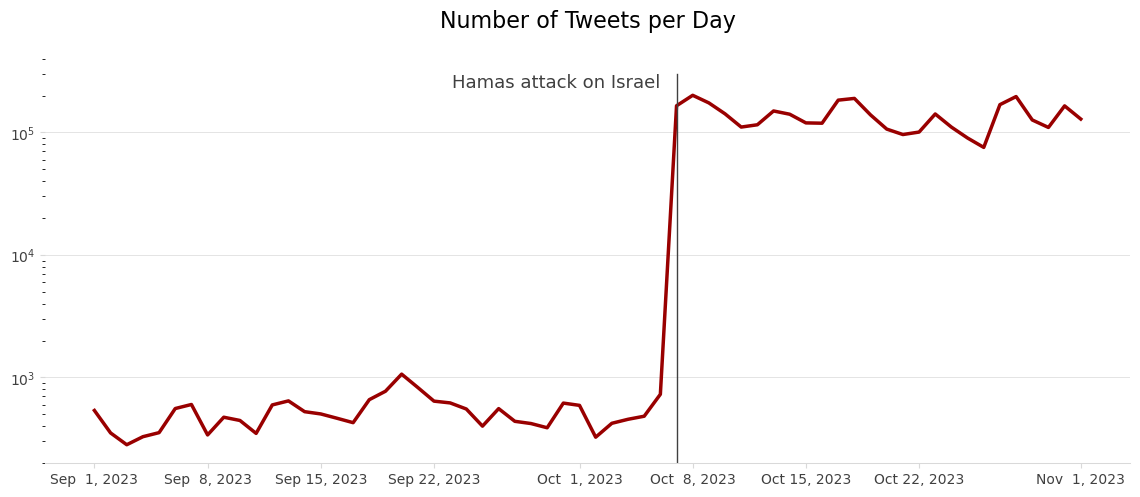

In [247]:
ax = create_emotion_timeline_figure()

plt.plot(twitter_daily_counts.index,
         twitter_daily_counts['date_time'],
         c = '#990000',
         linewidth = 2.5
         )

plt.yscale('log')

add_annotation(ax,
               "Hamas attack on Israel",
               pd.to_datetime(datetime(2023, 10, 7).date()),
               twitter_daily_counts['date_time'].max()+100000,
               horizontal_alignment='right',
               text_spacer=1)

plt.title(f"Number of Tweets per Day",
          fontsize=16,
          loc='center',
          pad=20)

plt.show()

## Count of Highest Confidence Emotion

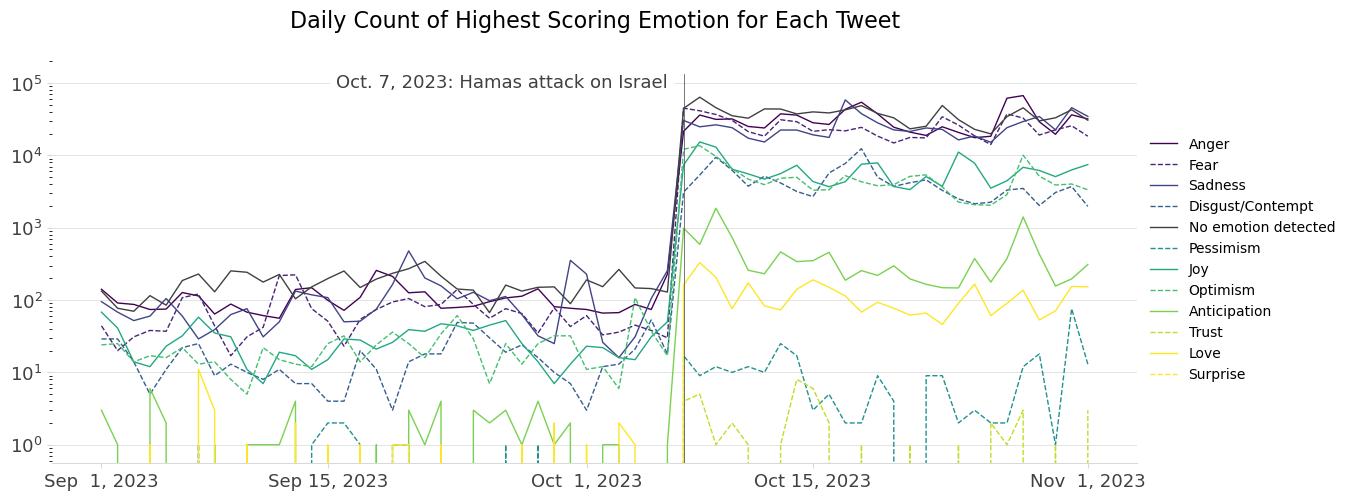

In [351]:
ax = create_emotion_timeline_figure()

# set to true to have all emotions except the
# one specified colored gray. This makes the
# specified emotion stand out
highlight = False  # True False
highlight_emotion = 'Sadness'

# emotion colors to change: Joy, Optimism, Anger

# get the order of emotions in descending order of
# average confidence, so highest confidence values
# are drawn last
emo_order = (twitter[['Anger', 'Anticipation', 'Disgust/Contempt', 'Fear',
                      'Joy', 'Love', 'Optimism', 'Pessimism',
                      'Sadness', 'Surprise', 'Trust', 'No emotion detected']]
                      .mean()
                      .sort_values()
                      .index)
emo_order = list(emo_order)[::-1]

# # get daily mean confidence values
# twitter_daily = (twitter[emo_order]
#                  .groupby(twitter['date_time'].dt.date)
#                  .mean())

# for each tweet get the emotion with the highest confidence
# and count the daily occurrence of the result
twitter_hc = twitter.copy()
twitter_hc['date'] = twitter_hc['date_time'].dt.date
twitter_hc['highest_emotion'] = twitter_hc[emo_order].idxmax(axis=1)
twitter_daily = (pd.DataFrame(twitter_hc
                              .groupby(['date', 'highest_emotion'])
                              .size())
                              .rename(columns={0:'count'})
                              .reset_index())

# make highlight emotion the last one in the list so it
# is drawn on top of others
# if highlight:
#     idx = emo_order.index(highlight_emotion)

#     # put highlight emotion at the end of the list
#     emo_order.remove(highlight_emotion)
#     emo_order.append(highlight_emotion)

#     # put the highlight emotion's color at the end of the list
#     highlight_color = colors.pop(idx)
#     colors.append(highlight_color)

# Get the Viridis colormap and normalize index
viridis = colormaps['viridis']
norm = colors.Normalize(vmin=0, vmax=len(emo_order) - 2)

# get start and end date of data as well as complete date range
start_date = twitter_daily['date'].min()
end_date = twitter_daily['date'].max()
date_range = pd.date_range(start_date, end_date, freq='D')

for i, emotion in enumerate(emo_order):
    # get counts for this emotion
    emo_data = twitter_daily[twitter_daily['highest_emotion']==emotion].copy()

    # ensure all days in the range are represented
    emo_data.set_index('date', inplace=True)
    emo_data = emo_data.reindex(date_range, fill_value=0).reset_index()
    emo_data.rename(columns={'index': 'date'}, inplace=True)

    line_width=1.0

    # if highlight & (emotion!=highlight_emotion):
    #     # color = '#000000' # '#a6a6a6' '#E7E6E6' '#767171' '#D0CECE' C9C9C9 595959
    #     line_width = 1.0
    #     alpha = 0.3

    # if highlight & (emotion==highlight_emotion):
    #     # if highlight_emotion in ['Anticipation', 'Joy', 'Love', 'Optimism', 'Trust', 'Surprise']:
    #     #     color = '#2c7bb6'
    #     # else:
    #     #     color = '#d7191c' # '#4f81bd' '#d7191c'  # 000000
    #     line_width=3.0
    #     alpha = 1.0
    
    # # specify emotions to get dashed lines
    # dashed_emotions = emo_order[1::2]
    # if emotion in dashed_emotions:
    #     linestyle = '--'
    # else:
    #     linestyle = '-'

    if emotion == 'No emotion detected':
        color = '#404040'
    else:
        color = viridis(norm(i))

    if ((i)%2==0):  # & (emotion != 'No emotion detected')
        linestyle = '-'
    # if emotion == 'No emotion detected':
    #     linestyle='dotted'
    else:
        linestyle = '--'

    plt.plot(emo_data['date'],
             emo_data['count'],
             linestyle=linestyle,
             label=emotion,
             c=color,
             linewidth=line_width,
             alpha=1)
    
    # # add annotation at the end of line
    # add_line_annotation(ax=ax,
    #                     text=emotion,
    #                     x=emo_data['date'].max(),
    #                     y0=emo_data['count'].iloc[-1],
    #                     y1=emo_data['count'].iloc[-1]+1)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=7))

add_annotation(ax,
               "Oct. 7, 2023: Hamas attack on Israel",
               pd.to_datetime(datetime(2023, 10,7).date()),
               twitter_daily['count'].max()*2,
               horizontal_alignment='right',
               line_thickness=0.5,
               text_spacer=1)

# add_annotation(ax,
#                "Tweet about the 23rd anniversary of the killing \nof 12-year-old Muhammad al-Durrah by Israeli \nforces retweeted 227 times.",
#                pd.to_datetime(datetime(2023, 9, 30).date()),
#                0.55,
#                horizontal_alignment='right',
#                text_spacer=1)

plt.yscale('log')


plt.legend(loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False)

# if highlight:
#     plt.title(f"Daily Mean Confidence for {highlight_emotion}",
#             fontsize=16,
#             loc='center',
#             pad=20)
# else:
plt.title("Daily Count of Highest Scoring Emotion for Each Tweet",
        fontsize=16,
        loc='center',
        pad=20)

plt.show()

## Thresholded Daily Tweet Counts

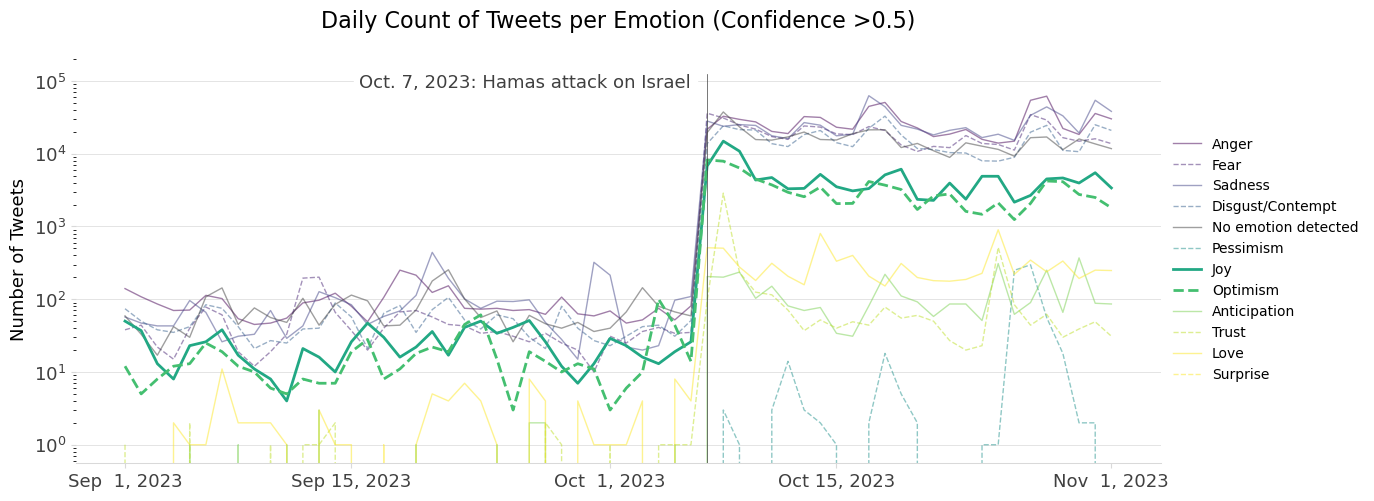

In [371]:
ax = create_emotion_timeline_figure()

# set to true to have all emotions except the
# one specified colored gray. This makes the
# specified emotion stand out
highlight = False  # True False
highlight_emotions = ['Joy', 'Optimism']

# emotion colors to change: Joy, Optimism, Anger

# get the order of emotions in descending order of
# average confidence, so highest confidence values
# are drawn last
emo_order = (twitter[['Anger', 'Anticipation', 'Disgust/Contempt', 'Fear',
                      'Joy', 'Love', 'Optimism', 'Pessimism',
                      'Sadness', 'Surprise', 'Trust', 'No emotion detected']]
                      .mean()
                      .sort_values()
                      .index)
emo_order = list(emo_order)[::-1]

# set minimum confidence value to consider emotion
# being in a tweet
thresh = 0.5
twit_mask = twitter[emo_order].copy()
twit_mask[twit_mask<thresh] = 0
twit_mask[twit_mask>=thresh] = 1
twit_mask['date_time'] = twitter['date_time']

# get counts of tweets per day
twitter_daily_counts = (twit_mask[emo_order]
                        .groupby(twitter['date_time'].dt.date)
                        .sum())

# make highlight emotion the last one in the list so it
# is drawn on top of others
colormap_indices = list(range(0, len(emo_order)))
if highlight:
    for e in emo_order:
        if e in highlight_emotions:
            idx = emo_order.index(e)

            # put highlight emotion at the end of the list
            emo_order.remove(highlight_emotion)
            emo_order.append(highlight_emotion)

            # put the highlight emotion's colormap index at end of list
            color_idx = colormap_indices.pop(idx)
            colormap_indices.append(color_idx)

# Get the Viridis colormap
viridis = colormaps['viridis']

# Normalizing the index for colormap
norm = colors.Normalize(vmin=0, vmax=12 - 2)


for c_idx, emotion in zip(colormap_indices, emo_order):
    # line_width=1.0

    # assign line color based on emotion
    if emotion == 'No emotion detected':
        color = '#404040'
    else:
        color = viridis(norm(c_idx))

    # assign dashed line type to every other line to
    # improve readability
    if ((c_idx)%2==0) | (emotion == 'No emotion detected'):
        linestyle = '-'
    else:
        linestyle = '--'

    # highlight certain lines by adjusting alpha and line width
    if (len(highlight_emotions)>0) & (emotion in highlight_emotions):
        alpha=1
        line_width=2.0
    elif (len(highlight_emotions)>0):
        alpha = 0.5
        line_width=1.0
    else:
        alpha = 1
        line_width=1.0

    plt.plot(twitter_daily_counts.index,
             twitter_daily_counts[emotion],
             linestyle=linestyle,
             label=emotion,
             c=color,
             linewidth=line_width,
             alpha=alpha)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=7))

add_annotation(ax,
               "Oct. 7, 2023: Hamas attack on Israel",
               pd.to_datetime(datetime(2023, 10,7).date()),
               twitter_daily_counts.max().max()*2,
               horizontal_alignment='right',
               line_thickness=0.5,
               text_spacer=1)

# add_annotation(ax,
#                "Tweet about the 23rd anniversary of the killing \nof 12-year-old Muhammad al-Durrah by Israeli \nforces retweeted 227 times.",
#                pd.to_datetime(datetime(2023, 9, 30).date()),
#                0.55,
#                horizontal_alignment='right',
#                text_spacer=1)

plt.yscale('log')

plt.ylabel("Number of Tweets", fontsize=13)

# if not highlight:
plt.legend(loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False)

# if highlight:
#     plt.title(f"Daily Mean Confidence for {highlight_emotion}",
#             fontsize=16,
#             loc='center',
#             pad=20)
# else:
plt.title("Daily Count of Tweets per Emotion (Confidence >0.5)",
        fontsize=16,
        loc='center',
        pad=20)

plt.show()